지금까지 합성곱 계층과 풀링 계층에 대해 살펴보았다. 이번 절에서는 이 두 계층을 파이썬으로 구현해보자. "5장 오차역전파법"에서 설명한 것처럼 이번 절에서 구현하는 클래스에도 forward와 backward 메소드를 추가하여 모듈로 이용할 수 있도록 하자.

합성곱 계층과 풀링 계층은 복잡해 보이지만, 사실 "트릭"을 사용하면 쉽게 구현할 수 있다. 이번 절에서는 그 트릭을 활용해 문제를 간단히 하면서 합성곱 계층을 구현해보자.

# 7.4.1 4차원 배열

앞에서 설명한 대로 CNN에서 계층 사이를 흐르는 데이터는 4차원 이다. 예를 들어 데이터의 형상이 (10,1,28,28)이라면, 이는 높이 28, 너비 28, 채널 1개인 데이터가 10개라는 이야기이다. 이를 파이썬으로 구현하면 다음과 같다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [2]:
x[0].shape

(1, 28, 28)

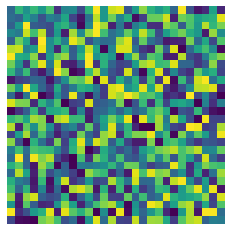

In [3]:
plt.imshow(x[0, 0])
plt.axis("off")
plt.show()

이처럼 CNN은 4차원 데이터르 다룬다. 그래서 합성곱 연산의 구현은 복잡해질 것 같지만, 다음 절에서 설명하는 im2col이라는 "트릭"이 문제를 단순하게 만들어준다.

# 7.4.2 im2col로 데이터 전개하기

합성곱 연산을 곧이곧대로 구현하려면 for문을 겹겹이 써야할 것이다. 생각만 해도 귀찮고, 또 넘파이에 for 문을 사용하면 성능이 떨어진다는 단점도 있다(넘파이에서는 원소에 접근할 때 for 문을 사용하지 않는 것이 바람직하다). 이번 절에서는 for 문 대신 im2col이라는 편의 함수를 사용해 간단하게 구현해보자.

im2col은 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는(펼치는) 함수이다. 다음과 같이 3차원 데이터에 im2col을 적용하면 2차원 행렬로 바뀐다(정확히는 배치 안의 데이터 수까지 포함한 4차원 데이터를 2차원으로 변환한다).

<img src=images/7_17.png height=100px width=500px>

im2col은 필터링 하기 좋게 입력 데이터를 전개한다. 구체적으로는 다음과 같이 입력 데이터에서 필터를 적용하는 영역(3차원 블록)을 한 줄로 늘어놓습니다. 이 전개를 필터를 적용하는 모든 영역에서 수행하는 게 im2col이다.

<img src=images/7_18.png height=100px width=500px>

필터 적용 영역을 앞에서부터 순서대로 1줄로 펼친다.

위 그림에서는 보기에 좋게끔 스트라이드를 크게 잡아 필터의 적용ㅇ 영역이 겹치지 않도록 했지만, 실제 상황에서는 영역이 겹치는 경우가 대부분이다. 필터 적용 영역이 겹치게 되면 im2col로 전개한 후의 원소 수가 원래 블록의 원소 수보다 많아진다. 그래서 im2col을 사용해 구현하면 메모리를 더 많이 소비하는 단점이 있다. 하지만 컴퓨터는 큰 행렬을 묶어서 계산하는 데 탁월하다. 예를 들어 행렬 계산 라이브러리(선형 대수 라이브러리) 등은 행렬 계산에 고도로 최적화되어 큰 행렬의 곱셈을 빠르게 계산할 수 있다. 그래서 문제를 행렬 계산으로 만들면 선형 대수 라이브러리를 활용해 효율을 높일 수 있다.

im2col로 입력 데이터를 전개한 다음에는 합성곱 계층의 필터(가중치)를 1열로 전개하고, 두 행렬의 곱을 계산하면 된다. 이는 완전연결 계층의 Affine 계층에서 한 것과 거의 같다.

# 7.4.3 합성곱 계층 구현하기

In [4]:
## image to column
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    # pad
    img = np.pad(input_data, [(0,0), (0,0), (pad,pad), (pad,pad)], "constant")
    
    # col
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            ## y:y_max:stride => out_h만큼의 행렬 만듦
            col[:,:,y,x,:,:] = img[:,:,y:y_max:stride,x:x_max:stride]
            
    ## transpose to N, out_h, out_w, C, reshape it a line with length N*out_h*out_w 
    ## -1: do what you want numpy
    col = col.transpose(0,4,5,1,2,3).reshape(N*out_h*out_w, -1)
    
    return col

In [5]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)
    
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:,:, y:y_max:stride, x:x_max:stride] += col[:,:,y,x,:,:]
            
    return img[:, :, pad:H+pad, pad:W+pad]

In [6]:
x1 = np.random.rand(1, 3, 7, 7) ## (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) ## (9, 75)

x2 = np.random.rand(10, 3, 7, 7) ## 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


(2, 1, 3, 3)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
(5, 5)
[[ 0.  1.  2.  5.  6.  7. 10. 11. 12. 25. 26. 27. 30. 31. 32. 35. 36. 37.]
 [ 1.  2.  3.  6.  7.  8. 11. 12. 13. 26. 27. 28. 31. 32. 33. 36. 37. 38.]
 [ 2.  3.  4.  7.  8.  9. 12. 13. 14. 27. 28. 29. 32. 33. 34. 37. 38. 39.]
 [ 5.  6.  7. 10. 11. 12. 15. 16. 17. 30. 31. 32. 35. 36. 37. 40. 41. 42.]
 [ 6.  7.  8. 11. 12. 13. 16. 17. 18. 31. 32. 33. 36. 37. 38. 41. 42. 43.]
 [ 7.  8.  9. 12. 13. 14. 17. 18. 19. 32. 33. 34. 37. 38. 39. 42. 43. 44.]
 [10. 11. 12. 15. 16. 17. 20. 21. 22. 35. 36. 37. 40. 41. 42. 45. 46. 47.]
 [11. 12. 13. 16. 17. 18. 21. 22. 23. 36. 37. 38. 41. 42. 43. 46. 47. 48.]
 [12. 13. 14. 17. 18. 19. 22. 23. 24. 37. 38. 39. 42. 43. 44. 47. 48. 49.]
 [50. 51. 52. 55. 56. 57. 60. 61. 62. 75. 76. 77. 80. 81. 82. 85. 86. 87.]
 [51. 52. 53. 56. 57. 58. 61. 62. 63. 76. 77. 78. 81. 82. 83. 86. 87. 88.]
 [52. 53. 54. 57. 58. 59. 62. 63. 64. 77. 78. 79. 82. 83. 84. 87

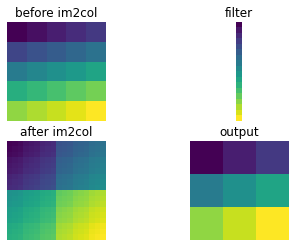

In [16]:
x3 = np.arange(100)
x3 = x3.reshape(2,2,5,5)
N, C, H, W = x3.shape
f3 = np.arange(18)
f3 = f3.reshape(1,2,3,3)
col3 = im2col(x3, 3, 3, stride=1, pad=0)  ## 필터의 크기는 3*3 = 9
f3 = f3.reshape(1, -1).T
out = (col3@f3).reshape(N, 3, 3, -1).transpose(0,3,1,2)
print(out.shape)

plt.subplot(221)
plt.imshow(x3[0,0,:,:])
plt.title("before im2col")
plt.axis("off")
print(x3[0,0,:,:])
print(x3[0,0,:,:].shape)

plt.subplot(223)
plt.imshow(col3)
plt.title("after im2col")
plt.axis("off")
print(col3)
print(col3.shape)

plt.subplot(222)
plt.imshow(f3)
plt.title("filter")
plt.axis("off")

plt.subplot(224)
plt.imshow(out[0,0,:,:])
plt.title("output")
plt.axis("off")

plt.show()

In [8]:
x = np.array([0,1,2,5,6,7,10,11,12,25,26,27,30,31,32,35,36,37])
y = np.arange(18).reshape(1,-1).T

x@y

array([4035])

여기에서는 두 가지 예를 보여주고 있다. 첫 번째는 배치 크기가 1(데이터 1개), 채널은 3개, 높이, 너비 각각 7개의 데이터이고, 두 번째는 배치 크기만 10이고 나머지는 첫 번재와 같다. im2col 함수를 적용한 두 경우 모두 2번재 차원의 원소는 75개이다. 이 값은 필터의 원소 수와 같다(채널 3개, $5 \times 5$ 데이터). 또한, 배치 크기가 1일 때는 im2col의 결과의 크기가 (9, 75)이고, 10일 때는 (90, 75)크기의 데이터가 저장된다.

이제 이 im2col을 사용하여 합성곱 계층을 구현해보자. 여기에서는 합성곱 계층을 Convolution 이라는 클래스로 구현해보자.

In [9]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.col = None
        self.col_W = None
        
        self.dW = None
        self.db = None
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        self.x = x
        self.col = im2col(x, FH, FW, self.stride, self.pad)
        self.col_W = self.W.reshape(FN, -1).T
        out = self.col @ self.col_W + self.b
        
        out = out.reshape(N, out_h, out_W, -1).transpose(0, 3, 1, 2)
        
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.dW = self.col.T @ dout
        self.dW = self.dW.transpose(1,0).reshape(self.W.shape)
        self.db = np.sum(dout, axis=0)
        
        dcol = dout @ self.col_W.T
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx

합성곱 계층은 필터(가중치), 편향, 스트라이드, 패딩을 인수로 받아 초기화한다. 필터는 (FN, C, FH, FW)의 4차원 형상이다. 여기서 FN은 필터 개수, C는 채널, FH는 필터 높이, FW는 필터 너비이다. 

앞의 합성곱 구현 코드에서 중요한 부분을 굵게 표시하였다. 이 부분에서 입력 데이터를 im2col로 전개하고 필터도 reshape을 사용해 2차원 배열로 전개한다. 그리고 이렇게 전개한 두 행렬의 곱을 구한다. 

필터를 전개하는 부분(코드 중 굵은 글씨)은 위 그림에서 보듯 각 필터 블록을 1줄로 평쳐 세운다. 이때 reshape의 두번 째 인수를 -1로 지정했는데, 이는 reshape이 제공하는 편의 기능이다. reshape에 -1을 지정하면 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되도록 적절히 묶어준다. 무슨 말이고 하니 앞의 코드에서 (10, 3, 5, 5) 형상을 한 다차원 배열 W의 원소 수는 총 750개이다. 이 배열에 reshape(10,-1)을 호출하면 750개의 원소를 10묶음으로, 즉 형상이 (10,75)인 배열로 만들어준다.

하나의 데이터를 1차원으로 변형하는 것이다. 필터도 마찬가지로 계산하여 데이터와 필터간의 행렬 곱의 결과는 앞서 본 블럭형태에 데이터에 여러개의 블록 필터들을 곱한 블럭 형태의 출력을 1차원으로 변형한 데이터가 출력된다. 편향을 적용한 후, 이를 원래의 형태인 (out_h, out_w, C)의 형태로 변환하고 이를 최종적으로 (N, C, OH, OW)의 4차원 데이터로 되돌린다. 여기서 사용한 transpose 함수는 다차원 배열의 축 순서를 바꿔주는 함수이다. 이 함수는 다음과 같이 인덱스를 지정하여 축의 순서를 변경할 수 도 있다.

<img src=images/7_20.png height=100px width=500px>

이상이 합성곱 계층의 forward 구현이다. im2col로 전개한 덕분에 완전연결 계층의 Affine 계층과 거의 똑같이 구현할 수 있다. 다음은 합성곱 계층의 역전파를 구현할 차례지만, Affine 계층의 구현과 공통점이 많아 따로 설명하지 않겠다. 주의할 게 하나 있는데, 합성곱 계층의 역전파에서는 im2col을 역으로 처리해야 한다. 이는 이 책이 제공하는 col2im 함수를 사용하면 된다. col2im을 사용한다는 점을 제외하면 합성곱 게층의 역전파는 Affine 계층과 똑같다.

# 7.4.4 풀링 계층 구현하기

풀링 계층 구현도 합성곱 계층과 마찬가지로 im2col을 사용해 입력 데이터를 전개한다. 단, 풀링의 경우엔 채널 쪽이 독립적이라는 점이 합성곱 계층 때와 다르다. 구체적으로는 다음과 같이 풀링 적용 영역을 채널마다 독립적으로 전개한다.

<img src=images/7_21.png height=100px width=500px>

일단 이렇게 전개한 후, 전개한 행렬에서 행별 최댓값을 구하고 적절한 형상으로 성형하기만 하면 된다. 그 과정은 다음과 같다.

<img src=images/7_22.png height=100px width=500px>

이상이 풀링 계층의 forward 처리 흐름이다. 다음은 이를 파이썬으로 구현한 코드이다.

In [19]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        ## 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        ## 최댓값
        self.x = x
        self.arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0,2,3,1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))  ## (N*out_h*out_w, pool_size)
        ## if arg_max[i]=3, dmax=[0,0,0,dout[i]]
        ## if arg_max[j]=1, dmax=[0,dout[j],0,0] 
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        ## (N, out_h, out_w, pool_size)
        dmax = dmax.reshape(dout.shape + (pool_size,))
        
        ## (N*out_h*out_w, pool_size)
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx